In [1]:
import torch
import pickle
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from omegaconf import OmegaConf
from PIL import Image
from torchvision import transforms
import hydra
import sys
import os
from pathlib import Path

In [2]:
project_root = Path().absolute().parent
sys.path.append(str(project_root))

print(f"Added {project_root} to Python path")

hydra_config_path = '../configs/tsne_visualization.yaml'
pkl_path = '../CheXpert-v1.0-small/chexpert_small.pkl' #TODO: adjust path

# csv_path = '../CheXpert-v1.0-small/train.csv'

Added d:\TUM\Semester 2\ADLM\vlp to Python path


In [3]:
# Load config
config = OmegaConf.load(hydra_config_path)

# Load preprocessed data
with open(pkl_path, 'rb') as f:
    data = pickle.load(f)

# data = pd.read_csv(csv_path)

In [4]:
data.head()


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [5]:
# DISEASE_LABELS = [
#     'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
#     'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation',
#     'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
#     'Pleural Other', 'Fracture', 'Support Devices'
# ]

DISEASE_LABELS = [
    'No Finding',
    'Atelectasis',
    'Cardiomegaly',
    'Consolidation',
    'Edema',
    'Pleural Effusion'
]

In [6]:
# Load model using Hydra
with hydra.initialize(config_path="../configs"):
    cfg = hydra.compose(config_name="tsne_visualization")
    model = hydra.utils.instantiate(cfg.model)
    
    # Load checkpoint with key remapping
    checkpoint = torch.load(cfg.checkpoint_path, map_location=torch.device('cpu'))
    
       
    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
        # Filter out text-related keys and keep only image-related ones
        filtered_state_dict = {
            k: v for k, v in state_dict.items() 
            if k.startswith('image_model') or k.startswith('net.image_model')
        }
        
        # Remove 'net.' prefix if present
        new_state_dict = {}
        for k, v in filtered_state_dict.items():
            new_key = k.replace('net.', '')
            new_state_dict[new_key] = v
        
        try:
            model.load_state_dict(new_state_dict, strict=False)
            print("Successfully loaded image model weights!")
        except Exception as e:
            print(f"Error loading state dict: {e}")
            print("\nAvailable keys in filtered checkpoint:", new_state_dict.keys())
            print("\nModel state dict keys:", model.state_dict().keys())
    
    if isinstance(model, torch.nn.Module):
        model.eval()
        print("Model is in evaluation mode")
    else:
        print(f"Warning: model is type {type(model)}, expected torch.nn.Module")

c:\Users\andre\anaconda3\envs\convirt_fed\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  


Successfully loaded image model weights!
Model is in evaluation mode


In [7]:
def get_full_image_path(relative_path): #TODO: adjust path
    # Remove 'CheXpert-v1.0-small/' from the start if it exists
    clean_path = relative_path.replace('CheXpert-v1.0-small/', '')
    # Join with project root and CheXpert directory
    return os.path.join(project_root, 'CheXpert-v1.0-small', clean_path)

# Update the feature extraction cell
def extract_features(model, image_paths, transform):
    features = []
    with torch.no_grad():
        for path in image_paths:
            # Get full path
            full_path = get_full_image_path(path)
            try:
                img = Image.open(full_path).convert('RGB')
                img = transform(img).unsqueeze(0)
                feat = model.image_model(img)
                features.append(feat.cpu().numpy())
            except Exception as e:
                print(f"Error processing {full_path}: {str(e)}")
    return np.vstack(features)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Extract features for a subset
# subset_size = len(data) #Use all data
subset_size = 2000
image_paths = data['Path'].values[:subset_size]
features = extract_features(model, image_paths, transform)
print("Features shape:", features.shape)

# Print first path to verify
print("\nExample path conversion:")
print("Original:", image_paths[0])
print("Full path:", get_full_image_path(image_paths[0]))

Features shape: (2000, 2048)

Example path conversion:
Original: CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg
Full path: d:\TUM\Semester 2\ADLM\vlp\CheXpert-v1.0-small\train/patient00001/study1/view1_frontal.jpg


In [8]:
def process_labels(original_labels):
    """
    Convert original labels to new categorization with 7 categories:
    - No Finding
    - Atelectasis
    - Cardiomegaly
    - Consolidation
    - Edema
    - Pleural Effusion
    - Other
    """
    new_labels = np.zeros((len(original_labels), 7))  # 7 categories including 'Other'
    
    # Map original indices to new indices (0-5, with 6 being 'Other')
    disease_map = {
        'No Finding': 0,
        'Atelectasis': 1,
        'Cardiomegaly': 2,
        'Consolidation': 3,
        'Edema': 4,
        'Pleural Effusion': 5
    }
    
    for i in range(len(original_labels)):
        if original_labels[i, 0] == 1:  # No Finding
            new_labels[i, 0] = 1
        else:
            found_selected = False
            for disease, new_idx in disease_map.items():
                old_idx = original_disease_labels.index(disease)
                if original_labels[i, old_idx] == 1:
                    new_labels[i, new_idx] = 1
                    found_selected = True
            
            # If no selected disease was found and it's not "No Finding"
            if not found_selected and original_labels[i, 0] != 1:
                new_labels[i, 6] = 1  # Other category

    return new_labels

original_disease_labels = [
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
    'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation',
    'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
    'Pleural Other', 'Fracture', 'Support Devices'
]

# Process the labels
labels_subset = process_labels(data[original_disease_labels].iloc[:subset_size].values)

In [9]:
tsne_params = cfg.tsne
tsne = TSNE(n_components=tsne_params.n_components, random_state=tsne_params.random_state, perplexity=tsne_params.perplexity, n_iter=tsne_params.n_iter, learning_rate=tsne_params.learning_rate)
tsne_results = tsne.fit_transform(features)
print("t-SNE results shape:", tsne_results.shape)

c:\Users\andre\anaconda3\envs\convirt_fed\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


t-SNE results shape: (2000, 2)


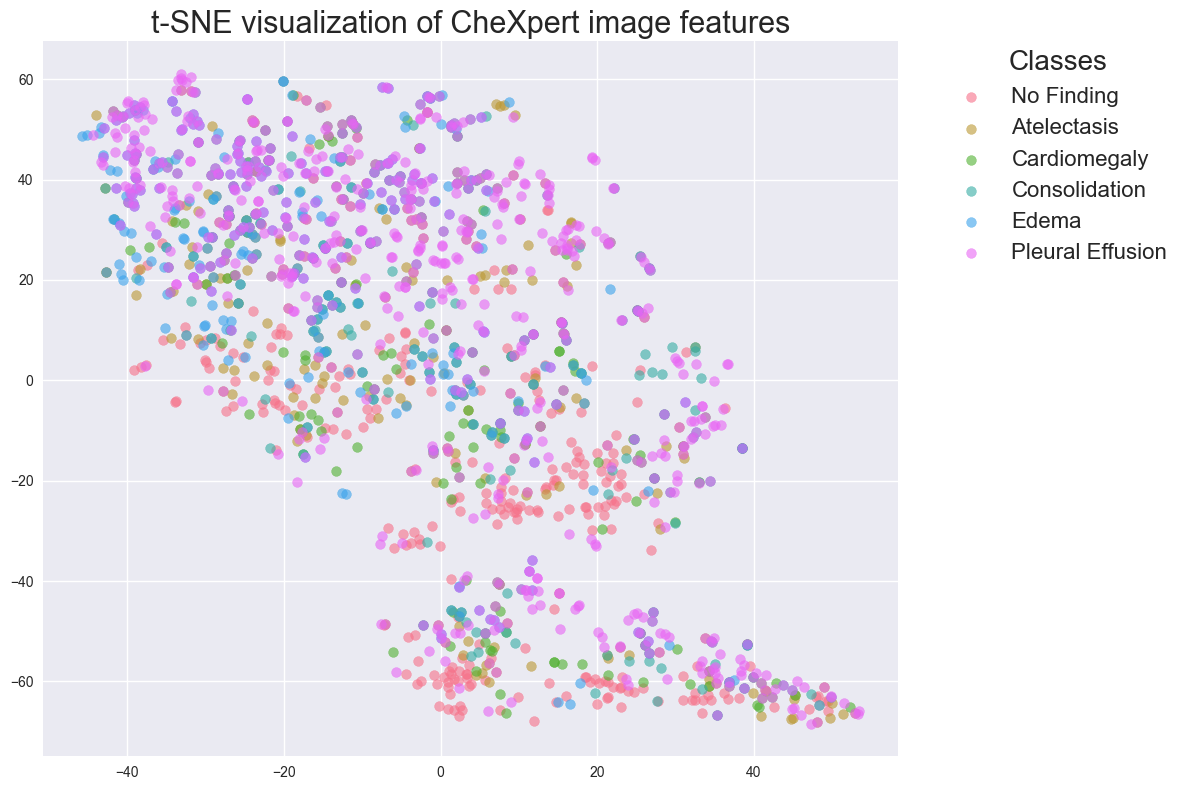

In [10]:
plt.style.use('seaborn')
plt.figure(figsize=(12, 8))

# Create a color map for each disease
colors = sns.color_palette('husl', n_colors=len(DISEASE_LABELS))
disease_color_dict = dict(zip(DISEASE_LABELS, colors))

# Plot each disease class
for i, disease in enumerate(DISEASE_LABELS):
    # Get indices where this disease is positive
    mask = labels_subset[:, i] == 1
    if mask.any():  # Only plot if there are positive cases
        plt.scatter(tsne_results[mask, 0], 
                   tsne_results[mask, 1],
                   c=[colors[i]],
                   label=disease,
                   alpha=0.6,
                   s=50)  # Adjust point size

# Customize the plot
plt.title('t-SNE visualization of CheXpert image features', fontsize=22)

# Add legend
plt.legend(title='Classes', 
          bbox_to_anchor=(1.05, 1), 
          title_fontsize=20,
          fontsize=16,
          loc='upper left',
          borderaxespad=0.)

# Adjust layout to prevent legend cutoff
plt.tight_layout()

plt.show()

In [11]:
# def plot_disease_tsne(disease_idx):
#     plt.figure(figsize=(12, 8))
#     scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
#                          c=labels_subset[:, disease_idx],
#                          cmap='viridis',
#                          alpha=0.6)
#     plt.colorbar(scatter)
#     plt.title(f't-SNE visualization for {DISEASE_LABELS[disease_idx]}')
#     plt.xlabel('t-SNE 1')
#     plt.ylabel('t-SNE 2')
#     plt.show()

# # Try different diseases
# for i, disease in enumerate(DISEASE_LABELS[:3]):  # First 3 diseases
#     plot_disease_tsne(i)